### Empirical method for estimation of endmembers

**Authors :** *Idriss ABDOULWAHAB & Amrin AKTER*

This notebook is dedicated on the estimation of endmembers using the empirical method from : 
B. Luo et al. 2013

The dataset we will use is from the paper :
B. Koirala et al., "A Multisensor Hyperspectral Benchmark Dataset For Unmixing of Intimate Mixtures," in IEEE Sensors Journal, doi: 10.1109/JSEN.2023.3343552

#### 1.1 Data loading

In [1]:
import glob
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Path of your dataset 
data = loadmat('dataset/ASD_Spectroradiometer/ASD_Spectroradiometer_dataset.mat')
data_matrix = data['ASD_Spectroradiometer']

N_s = len(data_matrix[:,1][0]) # Numbers of bands
N_a = data_matrix.shape[1] # Numbers of samples
X = np.ones((N_s,N_a))

for i in range (N_a):
    for j in range (N_s):
        X[j,i]=data_matrix[:,i][0][j][0]

## It's important to center the data in order to compute covariance and correlation
mean = np.mean(X, axis=1)
std = np.std(X, axis=1, ddof=1)
X_centered = X - mean[:, None]
X_normalized = X_centered / std[:, None]



#### 1.2 Covariance and correlation

In [3]:
K = np.cov(X_centered, rowvar=True)
R = np.corrcoef(X_normalized, rowvar=True)

eig_vals_K, eig_vecs_K = np.linalg.eig(K) 
eig_vals_R, eig_vecs_R = np.linalg.eig(R) 

/home/idrissabd6/miniconda3/envs/perso_env/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/idrissabd6/miniconda3/envs/perso_env/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Eigen values $\\lambda_i$ of K')

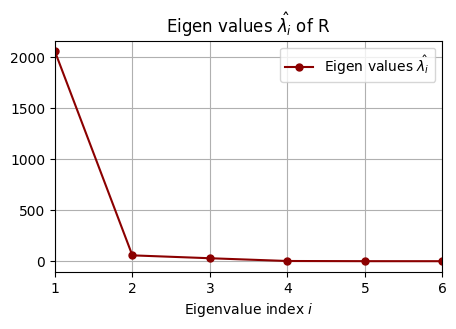

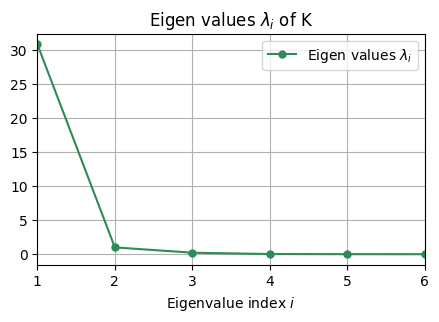

In [4]:
## Plot of eigen values
x_axis = np.linspace(1,N_s,N_s)
plt.figure(1, figsize=(5, 3))
plt.plot(x_axis,eig_vals_R,label='Eigen values $\hat{\lambda_i}$', marker='o', markersize=5, linestyle='-',color='darkred')
plt.grid()
plt.xlabel('Eigenvalue index $i$')
plt.legend()
plt.xlim([1,6])
plt.title("Eigen values $\hat{\lambda_i}$ of R")

plt.figure(2, figsize=(5, 3))
plt.plot(x_axis,eig_vals_K,label='Eigen values $\lambda_i$', marker='o', markersize=5, linestyle='-',color='seagreen')
plt.grid()
plt.legend()
plt.xlabel('Eigenvalue index $i$')
plt.xlim([1,6])
plt.title("Eigen values $\lambda_i$ of K")

### 1.3 Likelihood function

In [5]:
eig_R = eig_vals_R.real
eig_K = eig_vals_K.real

Z = eig_R-eig_K

A = np.zeros(N_s)
B = np.zeros(N_s)
H = np.zeros(N_s)
sigma = np.sqrt((2/N_a)*(eig_R**2 + eig_K**2))

# Log-likelihood function
for i in range (N_s):
    A[i] = -np.sum((Z[i:]**2)/(2*sigma[i:]))
    B[i] = -np.sum(np.log(np.sqrt(sigma[i:])))

H_log = A+B

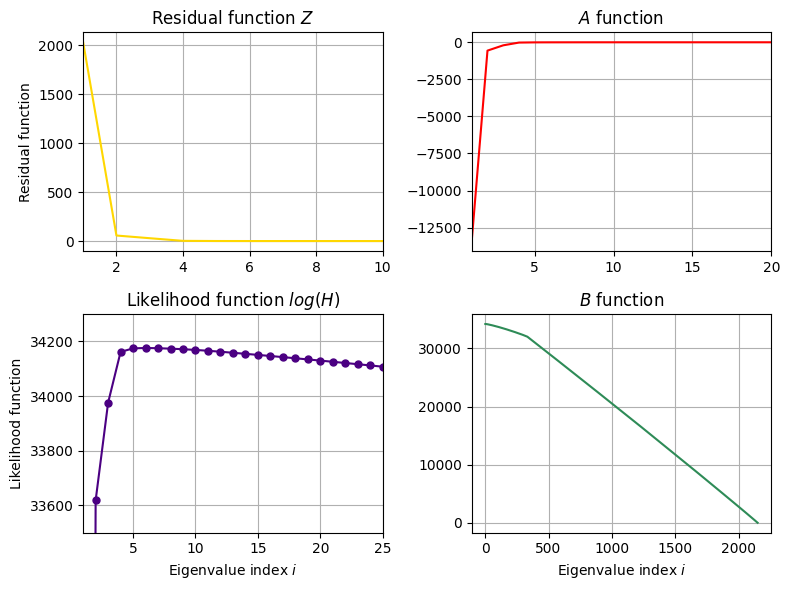

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].plot(x_axis, Z, color='gold')
axs[0, 0].grid()
axs[0, 0].set_xlim([1, 10])
axs[0, 0].set_ylabel('Residual function')
axs[0, 0].set_title("Residual function $Z$")

axs[0, 1].plot(x_axis, A, color='red')
axs[0, 1].grid()
axs[0, 1].set_xlim([1, 20])
axs[0, 1].set_title("$A$ function")

axs[1, 0].plot(x_axis, H_log, marker='o', markersize=5, linestyle='-',color='indigo')
axs[1, 0].grid()
axs[1, 0].set_xlim([1, 25])
axs[1, 0].set_ylim([33500, 34300])
axs[1, 0].set_xlabel('Eigenvalue index $i$')
axs[1, 0].set_ylabel('Likelihood function')
axs[1, 0].set_title("Likelihood function $log(H)$")

axs[1, 1].plot(x_axis, B, color='seagreen')
axs[1, 1].grid()
# axs[1, 1].set_xlim([1, 500])
axs[1, 1].set_xlabel('Eigenvalue index $i$')
axs[1, 1].set_title("$B$ function")


plt.tight_layout()
plt.show()

### 1.4 Endmembers $\hat{N_c}$ estimation

In [10]:
N_c = np.argmax(H_log)-1

# For image
print("The number of endmembers is",N_c)


The number of endmembers is 4


### 1.5 Identification of endmembers

In [13]:
V_endmembers_R = eig_vecs_R[:,:N_c]
V_endmembers_R = V_endmembers_R.real

V_endmembers_K = eig_vecs_K[:,:N_c]
V_endmembers_K = V_endmembers_K.real

S_R = X_normalized.T @ V_endmembers_R
S_K = X_centered.T @ V_endmembers_K

endmembers_index_R = np.argmax(np.abs(S_R), axis=0)+1
endmembers_index_K = np.argmax(np.abs(S_K), axis=0)+1

print("Endmembers index from R matrix :", endmembers_index_R)
print("Endmembers index from K matrix :", endmembers_index_K)

Endmembers index from R matrix : [205  36 330   1]
Endmembers index from K matrix : [205  36 330   1]


### 1.6 Ground truth dataset

In [14]:
ground_truth_data = loadmat('dataset/Ground_Truth_dataset.mat')
endmembers_index_gt = ground_truth_data['Endmembers_index'][0]

print("Endmembers index :", endmembers_index_gt)

Endmembers index : [330 120  36   8   1]


### 1.7 Identification

In [30]:
endmembers_mixtures = {330 : 'Kaolin',120 : 'Roof',36 : 'Red Clay',8 : 'Mixed Clay',1 : 'Calcium Hydroxide'}
endmembers_mixt_id = []
endmembers_index_final = np.unique(np.concatenate((endmembers_index_R, endmembers_index_K)))
endmembers_correct = list(set(endmembers_index_final) & set(endmembers_index_gt))

for i in range (len(endmembers_correct)):
    if endmembers_correct[i] in endmembers_mixtures:
        endmembers_mixt_id.append(endmembers_mixtures[endmembers_correct[i]])

print("Endmembers found with ELM : ",endmembers_index_final)
print("There is " + str(len(endmembers_correct)) + " corrected endmembers found")
print("The found mixtures are : " + str(endmembers_mixt_id))

Endmembers found with ELM :  [  1  36 205 330]
There is 3 corrected endmembers found
The found mixtures are : ['Calcium Hydroxide', 'Kaolin', 'Red Clay']
